<font size="6">Generate graph based on csv file</font>

In [ ]:
%pip install yfiles-jupyter-graphs --upgrade

In [9]:
%pip install lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 32.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import networkx as nx
import json
import csv
import matplotlib.pyplot as plt
from pyvis.network import Network
import re
from yfiles_jupyter_graphs import GraphWidget
from typing import Dict
import difflib
import langchain_chatgpt
import generate_graph
from networkx.algorithms.community import girvan_newman
import numpy as np
# def is_similar(str1, str2, threshold=0.9):
#    similarity_ratio= difflib.SequenceMatcher(None, str1, str2).quick_ratio()
#    return similarity_ratio >= threshold

<font size="6">Generate SameLine relationship graph</font>

In [2]:
#Use evidence name as the node name
def generate_graph_sameline_combine_samename(graph_file, evidence_file_graph):
    # 读取CSV文件
    graph_df = pd.read_csv(graph_file)
    # db_df = pd.read_csv(db_graph_file)
    # xml_df = pd.read_csv(xml_graph_file)
    # 创建无向图

    icon_map = {
    "name": "https://i.imgur.com/wo5vKco.png",
    "address": "https://i.imgur.com/el4Ef6u.png",    
    "phone number": "https://i.imgur.com/LNayAZi.png",
    "email": "https://i.imgur.com/B3nPm7v.png",
    "user name": "https://i.imgur.com/NZTWBco.png",
    "app name": "https://i.imgur.com/y03aAG4.png"
    }
    
    
    G = nx.Graph()  
    # name_mapping = {}  # 辅助映射，用于跟踪节点的实际名称
    G, similar_evidence_mapping = generate_graph.create_graph_object_sameline(G,graph_df)
    # G = generate_graph.create_graph_object_sameline(G,db_df)
    # G = generate_graph.create_graph_object_sameline(G,xml_df)



    # 找出所有属性为空的节点
    nodes_to_remove = []
    for node, attr in G.nodes(data=True):
        if not attr or all(v is None for v in attr.values()):
            nodes_to_remove.append(node)

    # 删除这些节点
    G.remove_nodes_from(nodes_to_remove)
    
    #查看删除节点后，图里的节点的attributes
    # for node, attrs in G.nodes(data=True):
    #     print(f'Node {node} has attributes {attrs}')
    
    #删除只和彼此相连的结点 Delete two nodes that are only connected to each other
    edges_to_remove = []
    for u, v in G.edges():
        # Check if these two nodes are only connected to each other
        if G.degree(u) == 1 and G.degree(v) == 1:
            edges_to_remove.append((u, v))
   
    # Remove the edges and the corresponding nodes if they meet the criteria
    for u, v in edges_to_remove:
        G.remove_edge(u, v)
        # Check if the two nodes have no other connections, if so, remove them
        if G.degree(u) == 0:
            G.remove_node(u)
        if G.degree(v) == 0:
            G.remove_node(v)

    # 删除没有边的节点
    nodes_with_no_edges = [node for node, degree in G.degree() if degree == 0]# 因为删除节点会改变G.nodes，先创建一个列表复制
    for node in nodes_with_no_edges:
        G.remove_node(node)           
           
    
    # 计算接近中心性 （在这之前要先去掉单独的点，要不然会被影响）
    closeness_centrality = nx.closeness_centrality(G)

    # 计算介数中心性
    betweenness_centrality = nx.betweenness_centrality(G)
    
    # 计算特征向量中心性
    # eigenvector_centrality = nx.eigenvector_centrality(G) 

    # 计算度数（degree）
    degree = dict(G.degree())
        
    # 4. 计算每个中心性的中位数
    closeness_median = np.median(list(closeness_centrality.values()))
    betweenness_median = np.median(list(betweenness_centrality.values()))
    # eigenvector_median = np.median(list(eigenvector_centrality.values()))
    
    degree_median = np.median(list(degree.values()))

    # 打印中位数结果
    print(f"Closeness Centrality Median: {closeness_median}")
    print(f"Betweenness Centrality Median: {betweenness_median}")
    # print(f"Eigenvector Centrality Median: {eigenvector_median}") 
    print(f"Degree Median: {degree_median}")



    """
    # 设置接近中心性的阈值
    closeness_threshold = 0.134  # 根据实际情况调整这个值

    # 找到接近中心性低于阈值的节点
    low_closeness_nodes = [node for node, cc in closeness.items() if cc < closeness_threshold]

    # # 从图中移除这些节点
    for node in low_closeness_nodes:
        G.remove_node(node)
    """
    
    """
    # 基于度数来进行过滤
    degree_threshold = 3
    low_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree <= degree_threshold]
    G.remove_nodes_from(low_degree_nodes)
    """
    
    
    # # 计算特征向量中心性
    # eigenvector = nx.eigenvector_centrality(G)

    # # 设置特征向量中心性阈值
    # eigenvector_threshold = 0.0000000000003326

    # # 找到特征向量中心性低于阈值的节点
    # low_eigenvector_nodes = [node for node, ec in eigenvector.items() if ec < eigenvector_threshold]

    # # 从图中移除这些节点
    # G.remove_nodes_from(low_eigenvector_nodes)
    



    # """
    # # 使用介数中心性来进行过滤
    # betweenness = nx.betweenness_centrality(G)

    # # 设置介数中心性的阈值
    # betweenness_threshold = 0.0001  # 根据实际情况调整

    # # 找到介数中心性低于阈值的节点
    # low_betweenness_nodes = [node for node, bc in betweenness.items() if bc < betweenness_threshold]

    # # 移除这些节点
    # G.remove_nodes_from(low_betweenness_nodes)
    # """
    
    # 删除没有边的节点
    nodes_with_no_edges = [node for node, degree in G.degree() if degree == 0]# 因为删除节点会改变G.nodes，先创建一个列表复制
    for node in nodes_with_no_edges:
        G.remove_node(node)
   

    # print(G.nodes[node]['color'] for node in G.nodes())
    # 绘制图形
    # pos = nx.spring_layout(G,k=5)
    # pos = nx.nx_agraph.graphviz_layout(G,prog="neato")
    # colors = [G.nodes[node]['color'] for node in G.nodes()]
    edge_styles = nx.get_edge_attributes(G, 'style')
    edge_widths = nx.get_edge_attributes(G, 'width')
    edge_colors = nx.get_edge_attributes(G, 'color')
    # print(G)
    # print(len(G))
    # print(len(node_colors_map))
    # print(node_number) 
 
   
    #node_color=colors,
    nx.draw(G, with_labels=True, node_size=120,  font_size=10, font_color='black', edge_color=list(edge_colors.values()), style=list(edge_styles.values()), width=list(edge_widths.values()))
    
    ##use plt to show the graph
    # nx.draw_networkx_edges(G, pos, edge_color=list(edge_colors.values()), style=list(edge_styles.values()), width=list(edge_widths.values()))
    plt.figure(figsize=(600,600),dpi=1000)
    plt.show()
    

    ########
    ##Use pyvis package to draw interactive graph
    # net = Network('1000px', '1080px')
    # # net.from_nx(G)
  
    # for node, node_attrs in G.nodes(data=True):
    #     # 以下一行代码在添加节点到pyvis图时设置title属性
    #     # print(node)
    #     # print(node_attrs)
    #     net.add_node(node, label=node, title=f'Evidence Number: {node_attrs["evidence_number"]}   Type: {node_attrs["evidence_type"]}',  size=20, ) #color=node_attrs['color'],

    # for from_node, to_node, edges_attr in G.edges(data=True):
    #     net.add_edge(from_node, to_node, title=f"Connection from {from_node} to {to_node}", width=0.5, color='black')
    
    # net.show_buttons(filter_=['physics'])


    # print("pyvis graph information:")
    #########
    
    # 输出节点和边的数量
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    
    
    #删除内部点两两互相连接的完全子图
    generate_graph.remove_complete_subgraphs(G)
    
    # Create a dictionary to store nodes and their related edges
    node_edges_dict = {node: list(G.edges(node)) for node in G.nodes()}
    # Print the dictionary used for analyze
    print("Result dictionary for this graph node and edge:")
    for index, (node, edges) in enumerate(node_edges_dict.items()):
        print(f"{index}: {node} : {edges}")


    #Add the related app node to the exist node in the graph
    # G= generate_graph.graph_add_app_node(G, evidence_file_graph, similar_evidence_mapping)

    ##Use yfiles graph
    nodes = []
    edges = []
    def custom_styles_mapping_image(item: Dict):
        icon = icon_map[item['properties']['evidence_type']]
            
        return {
            'image': icon
        }

    
    w = GraphWidget(graph=G)
    w.set_node_styles_mapping(custom_styles_mapping_image)
    w.get_node_styles_mapping()
    
    # display(w)
    w.show()
    print(w.nodes)
    return G

{'thisisdfir@gmail.com': 'thisisdfir@gmail.com', '16505434800@s.whatsapp.net': '16505434800@s.whatsapp.net', '1,0@s.whatsapp.net': '16505434800@s.whatsapp.net', '19195790479@s.whatsapp.net': '16505434800@s.whatsapp.net', '0@s.whatsapp.net': '16505434800@s.whatsapp.net', 'josh': 'Josh Hickman', 'Josh': 'Josh Hickman', 'Josh Hick': 'Josh Hickman', 'Joshua Hick': 'Josh Hickman', 'josh_hickman': 'Josh Hickman', 'Hickman, Josh': 'Josh Hickman', 'Joshua K Hickman': 'Josh Hickman', 'Joshua Hickman': 'Josh Hickman', 'josh hickman': 'Josh Hickman', 'Hickman': 'Josh Hickman', 'hickman': 'Josh Hickman', 'Josh Hickman': 'Josh Hickman', 'Christine Teigen': 'Chrissy Teigen', 'Chrissy Teigen': 'Chrissy Teigen'}
Closeness Centrality Median: 0.10035505430242271
Betweenness Centrality Median: 0.0
Degree Median: 2.0


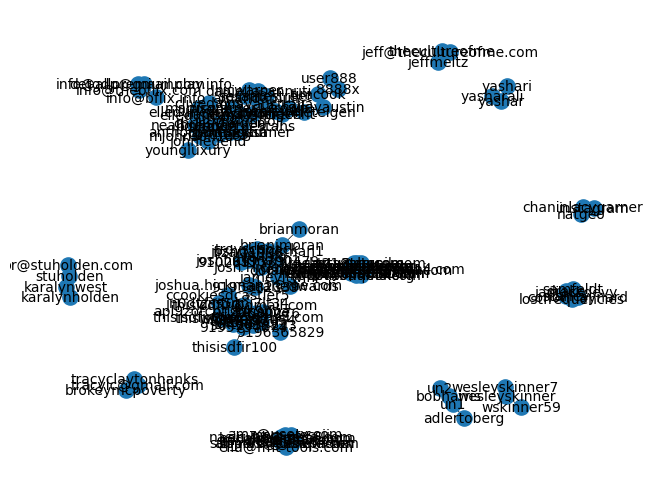

<Figure size 600000x600000 with 0 Axes>

Number of nodes: 127
Number of edges: 325
独立的完全子图: [['adobeflashcom', 'newmozfacebookcom', 'rebeccahoppkins@gmail.com', 'flashxadobecom', 'noopusoutlookcom', 'helpervidscrabcom', 'dojadewaskurwa@gmail.com', 'trtv3trtvcom', 'aytacabccom', 'bcvx5nqm9lorg', 'guzcerq6konet', 'lugcla21@gmail.com', 'colmeryopmailcom', 'liirosfacebookcom', 'fplayeradobeflash', 'wxtui502n2xce9jno14', 'toolbaraskcom'], ['support@seovpn.net', 'nasiri_ali@mefa.com', 'ali_nasiri@mefa.com', 'ali@mefa.com', 'amz@userx.com', 'nasiri@mefa.com', 'lin.Vin@userx.com', 'ella@fmt-tools.com', 'mouselessjj', 'benalio@gmail.com'], ['detgdp@gmail.com', 'info@allpremiumplay.info', 'info@thebflix.com', 'info@bflix.info'], ['brokeymcpoverty', 'tracyclaytonhanks', 'tracylc@gmail.com'], ['instagram', 'chaninlacygarner', 'natgeo'], ['jeff@thecultureofme.com', 'thecultureofme', 'jeffmeltz'], ['janieckdevy', 'conormaynard', 'lostfrequencies', 'starley', 'samfeldt', 'drake']]
Result dictionary for this graph node and edge:
0: thisisdfi

GraphWidget(layout=Layout(height='800px', width='100%'))

[{'id': 0, 'properties': {'evidence_number': '0.0.0', 'evidence_type': 'email', 'color': 'yellow', 'label': 'thisisdfir@gmail.com'}, 'color': '#15AFAC', 'styles': {'image': 'https://i.imgur.com/B3nPm7v.png'}, 'label': 'thisisdfir@gmail.com', 'scale_factor': 1.0, 'type': '#15AFAC', 'size': (55.0, 55.0), 'position': (0.0, 0.0)}, {'id': 1, 'properties': {'evidence_number': '1.0.0', 'evidence_type': 'name', 'color': 'skyblue', 'label': 'Josh Hickman'}, 'color': '#15AFAC', 'styles': {'image': 'https://i.imgur.com/wo5vKco.png'}, 'label': 'Josh Hickman', 'scale_factor': 1.0, 'type': '#15AFAC', 'size': (55.0, 55.0), 'position': (0.0, 0.0)}, {'id': 2, 'properties': {'evidence_number': '6.0.0', 'evidence_type': 'email', 'color': 'yellow', 'label': 'thisisdfirtwo@gmail.com'}, 'color': '#15AFAC', 'styles': {'image': 'https://i.imgur.com/B3nPm7v.png'}, 'label': 'thisisdfirtwo@gmail.com', 'scale_factor': 1.0, 'type': '#15AFAC', 'size': (55.0, 55.0), 'position': (0.0, 0.0)}, {'id': 3, 'properties': {

In [3]:
graph_file = "/home/hzhou/llama2/llama/experiment_result/result/Apps_in_the_document/graphfiles/graphstep1_5evidence_combinefiles_Apps_in_the_Document.csv"
evidence_file_graph= "/home/hzhou/llama2/llama/experiment_result/result/Apps_in_the_document/6evidence_combinefiles_after_chatgpt_analyze_App_in_the_Document.csv"
Graph_information=generate_graph_sameline_combine_samename(graph_file, evidence_file_graph)

In [4]:
# 假设已分割成多个子图，可以通过 connected_components 找到子图

# 获取所有连通子图
subgraphs = [Graph_information.subgraph(c) for c in nx.connected_components(Graph_information)]

# 方法1: 根据度中心性找到中心节点
def find_center_degree(subgraph):
    centrality = nx.degree_centrality(subgraph)
    return max(centrality, key=centrality.get)

# 遍历子图，计算每个子图的中心节点
for i, subgraph in enumerate(subgraphs):
    center_degree = find_center_degree(subgraph)

    print(f"子图 {i+1}:")
    print(f"  - 度中心性中心节点: {center_degree}")

子图 1:
  - 度中心性中心节点: thisisdfir@gmail.com
子图 2:
  - 度中心性中心节点: wesleyskinner
子图 3:
  - 度中心性中心节点: Chrissy Teigen
子图 4:
  - 度中心性中心节点: karalynwest
子图 5:
  - 度中心性中心节点: yasharali
子图 6:
  - 度中心性中心节点: un1


In [5]:
import json
# 将图保存为 JSON 文件
with open("/home/hzhou/llama2/llama/experiment_result/result/Apps_in_the_document/graphfiles/experiment4_graph.json", "w") as f:
    json.dump(nx.node_link_data(Graph_information), f)

In [2]:
# 从 JSON 文件加载图
with open("/home/hzhou/llama2/llama/experiment_result/result/Apps_in_the_document/graphfiles/graph.json", "r") as f:
    data = json.load(f)

G_loaded = nx.node_link_graph(data)

# 检查图结构
print(G_loaded.nodes)
print(G_loaded.edges)

['thisisdfir@gmail.com', 'Josh Hickman', 'thisisdfirtwo@gmail.com', '9195790479', 'wesleyskinner', 'wskinner59', 'wesleyskinner7', '9195794674', 'rickygervais', 'jeremyclarkson', 'otienoterry', 'fizart1998', 'joshhickman01', '', 'thisisdfir', 'sirwaltercoffeekitchen242smainstsuite118hollyspringsnc27540', 'greenoakspkwyandnc55bypasse', 'sirwaltercoffeekitchen', '0242smainstsuite118hollyspringsnc27540', '242smainstsuite118hollyspringsnc27540', 'thisis', 'blueline', 'imagineercoltdsanxcoltd', 'thewaltdisneycompanyjapanltd', 'tvtokyocommunicationscorporationsnoopy', 'moomincharacters', 'joshuahickman1', 'venmo', 'joshua.hickman1@me.com', 'wishdates', 'lovingfeel', '9102697333', 'timcook', 'Chrissy Teigen', 'kalenallen', 'courtneyturner', 'cortne85', 'brianmoran', 'brianjmoran', 'sarahedwards', 'iamevltwin', 'jeffmeltz', 'jeff@thecultureofme.com', 'thecultureofme', 'stuholden', 'pr@stuholden.com', 'karalynholden', 'karalynwest', 'tracyclaytonhanks', 'tracylc@gmail.com', 'brokeymcpoverty', '

In [10]:
#将node根据不同type合并为array
# 创建字典以根据 evidence_type 存储节点
type_to_nodes = {
    'name': [],
    'address': [],
    'phone number': [],
    'email': []
}

# 遍历所有节点并根据 evidence_type 进行分组
for node, attributes in Graph_information.nodes(data=True):
    evidence_type = attributes['evidence_type']
    type_to_nodes[evidence_type].append(node)

# 获取结果数组
name_array = type_to_nodes['name']
address_array = type_to_nodes['address']
phone_number_array = type_to_nodes['phone number']
email_array = type_to_nodes['email']

# 打印结果
print("Name nodes:", name_array)
print("Address nodes:", address_array)
print("Phone number nodes:", phone_number_array)
print("Email nodes:", email_array)

Name nodes: ['Josh Hickman', 'Sally', 'Jessica Hyde', 'Cony', 'Hello Kitty', 'Siro', 'Barchal', 'Winnie the Pooh', 'Christopher Robin', 'Mimmy', 'ThisIsDFIR', 'Clara Bacou', 'HOLLY SPRINGS', 'Amanda Mauer', 'Ashley Feinberg', 'John', 'Michael Estrella', 'Chuck', 'Stella', 'Matilda', 'Choklate', 'Aaron Sprinkle', 'Daniel Pak', 'Smokey Brights', 'Andrew Joslyn', 'Wanz', 'Shelby Earl', 'Super Square', 'Otieno Terry', 'The Gods Themselves', 'Justin', 'Napoleon Dynamite', 'Cuppy', 'Minseung Song', 'Komo', 'Sanat Rath', 'The Bald Jedi', 'Courtney Turner', 'Jonathan Rajewski', 'Simson Garfinkel', 'Chris Geidner', 'Erfon Elijah', 'Judy E Heath', 'Louis Peitzman', 'Brian Moran', 'Beth Comstock', 'Sady Paulson', 'Preet Bharara', 'Stu Holden', 'Sam Stein', 'Karalyn Holden', 'Jason Bailey', 'Jen', 'Daniel Dale', 'Liz Rabban', 'Richard Lawson', 'Adam Dorn', 'George Soros', 'Gene Park', 'Elizabeth Thorp', 'Annalie Contreras', 'Erin Ryan', 'Meghan Markle', 'Anthony Anderson', 'Luna', 'Mariisonn', 'Je

<font size="6">Generate SameTable relationship graph</font>

In [10]:
def generate_graph_sametable(input_file):
    # 读取CSV文件
    df = pd.read_csv(input_file)

    # 创建无向图
    G = nx.Graph()
    node_colors_map=[]
    # 遍历每一行
    for index, row in df.iterrows():
        # 获取节点信息
        node_number= row['node_evidence_number']
        evidence_name = row['node_evidence']
        evidence_type = row['evidence_type']
        
        # 将evidence_type信息加入生成的node中
        node_attributes = {'evidence_name':evidence_name,'evidence_type': evidence_type}
        if evidence_type=="name":
            G.add_node(node_number, color='red',**node_attributes)
            node_colors_map.append('red')
        elif evidence_type=="address":
            G.add_node(node_number, color='skyblue',**node_attributes)
            node_colors_map.append('skyblue')
        elif evidence_type=="phone number":
            G.add_node(node_number, color='yellow',**node_attributes)
            node_colors_map.append('yellow')
        elif evidence_type=="email":
            G.add_node(node_number, color='orange',**node_attributes)
            node_colors_map.append('orange')
        


        # 判断edge_relationship_sameline是否为空
        if not pd.isna(row['edge_relationship_sametable']):
            # 解析edge_relationship_sameline中的数组
            edges_sameline = eval(row['edge_relationship_sametable'])
            
            # 添加边，并设置为最粗的实线
            for edge in edges_sameline:
                if not G.has_edge(edge[0], edge[1]):  # Check if an edge exists between nodes
                    G.add_edge(edge[0], edge[1], style='solid', width=0.1, color='grey')



    # 绘制图形
    # pos = nx.spring_layout(G,k=5)
    pos = nx.spring_layout(G,k=100)
    edge_styles = nx.get_edge_attributes(G, 'style')
    edge_widths = nx.get_edge_attributes(G, 'width')
    edge_colors = nx.get_edge_attributes(G, 'color')
    print(G)
    print(len(G))
    print(len(node_colors_map))
    # print(node_number)
 
   

    nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors_map, font_size=5, font_color='black',edge_color=list(edge_colors.values()), style=list(edge_styles.values()), width=list(edge_widths.values()))
    
    # nx.draw_networkx_edges(G, pos, edge_color=list(edge_colors.values()), style=list(edge_styles.values()), width=list(edge_widths.values()))
    plt.figure(figsize=(600,600),dpi=1000)
    plt.show()
    
    #Use pyvis package to draw interactive graph
    # net = Network('1000px', '1000px')
    # net.from_nx(G)
    # net.show("graph_samtable.html", notebook=False)



Graph with 16 nodes and 14 edges
16
16


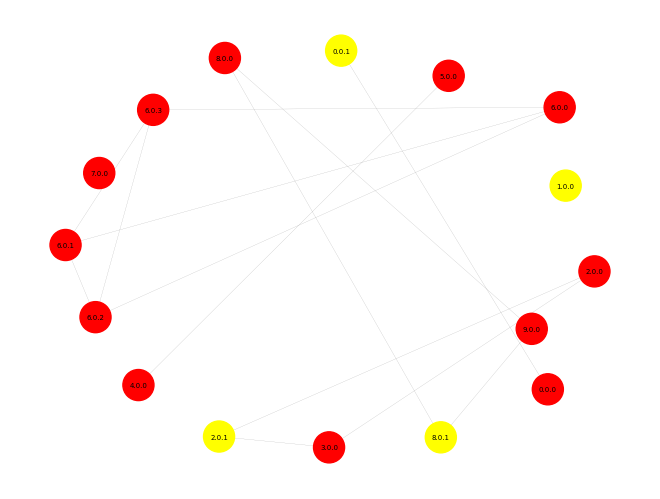

<Figure size 600000x600000 with 0 Axes>

In [11]:
step2_output_file = "/home/hzhou/llama2/llama/experiment_result/graphstep2_Android10_imo.csv"

generate_graph_sametable(step2_output_file)

<font size="6">Generate SameDatabase relationship graph</font>

In [21]:
def generate_graph_samedatabase(input_file):
    # 读取CSV文件
    df = pd.read_csv(input_file)

    # 创建无向图
    G = nx.Graph()
    node_colors_map=[]
    # 遍历每一行
    for index, row in df.iterrows():
        # 获取节点信息
        node_number= row['node_evidence_number']
        evidence_name = row['node_evidence']
        evidence_type = row['evidence_type']
        
        # 将evidence_type信息加入生成的node中
        node_attributes = {'evidence_name':evidence_name,'evidence_type': evidence_type}
        if evidence_type=="name":
            G.add_node(node_number, color='red',**node_attributes)
            node_colors_map.append('red')
        elif evidence_type=="address":
            G.add_node(node_number, color='skyblue',**node_attributes)
            node_colors_map.append('skyblue')
        elif evidence_type=="phone number":
            G.add_node(node_number, color='yellow',**node_attributes)
            node_colors_map.append('yellow')
        elif evidence_type=="email":
            G.add_node(node_number, color='orange',**node_attributes)
            node_colors_map.append('orange')
        


        # 判断edge_relationship_sameline是否为空
        if not pd.isna(row['edge_relationship_samedatabase']):
            # 解析edge_relationship_sameline中的数组
            edges_sameline = eval(row['edge_relationship_samedatabase'])
            
            # 添加边，并设置为最粗的实线
            for edge in edges_sameline:
                if not G.has_edge(edge[0], edge[1]):  # Check if an edge exists between nodes
                    G.add_edge(edge[0], edge[1], style='solid', width=0.1, color='lightcoral')



    # 绘制图形
    # pos = nx.spring_layout(G,k=5)
    pos = nx.spring_layout(G,k=100)
    edge_styles = nx.get_edge_attributes(G, 'style')
    edge_widths = nx.get_edge_attributes(G, 'width')
    edge_colors = nx.get_edge_attributes(G, 'color')
    print(G)
    print(len(G))
    print(len(node_colors_map))
    # print(node_number)
 
   

    nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors_map, font_size=5, font_color='black',edge_color=list(edge_colors.values()), style=list(edge_styles.values()), width=list(edge_widths.values()))
    
    # nx.draw_networkx_edges(G, pos, edge_color=list(edge_colors.values()), style=list(edge_styles.values()), width=list(edge_widths.values()))
    plt.figure(figsize=(600,600),dpi=1000)
    plt.show()
    #Use pyvis package to draw interactive graph
    # net = Network('1000px', '1000px')
    # net.from_nx(G)
    # net.show("graph_samline.html", notebook=False)
    # 显示图形
    # Enable interactive mode for matplotlib
    

Graph with 260 nodes and 20370 edges
260
260


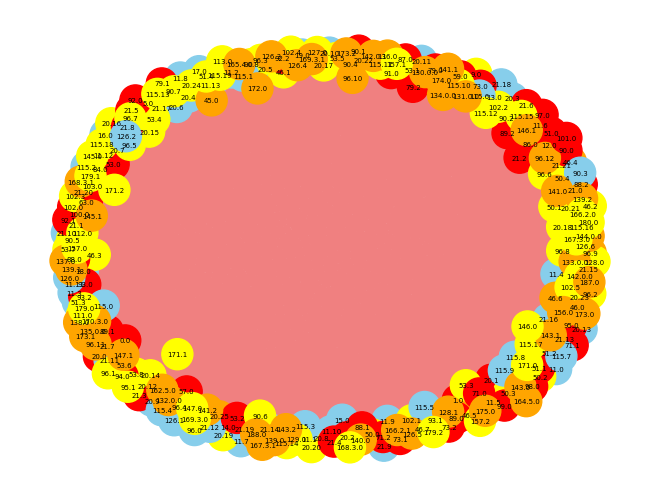

<Figure size 600000x600000 with 0 Axes>

In [23]:
step2_output_file = "/home/hzhou/llama2/llama/experiment_result/graphstep2.2.csv"
generate_graph_samedatabase(step2_output_file)

<font size="6">Generate Official Document Graph</font>

In [10]:
#Use evidence name as the node name
def generate_graph_official_document_sameapp(input_file):
    # 读取CSV文件
    df = pd.read_csv(input_file)

    # 创建无向图
    G = nx.Graph()
    color_map = {
    "name": "skyblue",
    "address": "green",
    "phone number": "red",
    "email": "yellow",
    "user name": "orange"
    }
    # 遍历每一行
    name_mapping = {}  # 辅助映射，用于跟踪节点的实际名称
    x=0
    
    
    #analyze node
    for index, row in df.iterrows():
        
        # 获取节点信息
        node_number= row['node_evidence_number']
        evidence_name = row['node_evidence']
        evidence_type = row['evidence_type']
        node_color = color_map[evidence_type]
        # 将evidence_type信息加入生成的node中
        node_attributes = {'evidence_number':node_number,'evidence_type': evidence_type, "color": node_color}
        print(f"evidence number: {node_number}")
        evidence_name_lower = evidence_name.lower()  # 记录当前键值的小写
        # 检查节点是否已经存在
        
        
        if evidence_name_lower in name_mapping:
            # 合并属性，将新属性添加到节点中
            print(G.nodes())
            original_node_name = name_mapping[evidence_name_lower]  # 使用映射中的实际节点名称来合并属性
                
            existing_attrs = G.nodes[original_node_name]   #existing_attrs存储这个已存在节点的attribute信息
            
            for key, value in node_attributes.items():
                if key in existing_attrs:
                    # 如果属性已存在，将值合并为列表
                    if(key== "color"):     #确保属性中没有相同的值，主要是为了不重复添加颜色
                        continue
                    else:
                        if isinstance(existing_attrs[key], list):
                            existing_attrs[key].append(value)
                        else:
                            existing_attrs[key] = [existing_attrs[key], value]
                else:
                    existing_attrs[key] = value
            G.nodes[original_node_name].update(existing_attrs)
        else:
            # 如果节点不存在，直接添加
            G.add_node(evidence_name, **node_attributes)
            name_mapping[evidence_name_lower] = evidence_name
            # print(G.nodes())

#analyze edge
    for index, row in df.iterrows():
        
        # 判断edge_relationship_sameline是否为空
        if not pd.isna(row['edge_relationship_sameapp']):
            # 解析edge_relationship_sameline中的数组
            edges_sameline = eval(row['edge_relationship_sameapp'])
           
            # 添加边，并设置为最粗的实线
            for edge in edges_sameline:
                actual_from_node_name = df[df['node_evidence_number'] == edge[0]]['node_evidence'].values  #原本的from_node的名字
                actual_to_node_name = df[df['node_evidence_number'] == edge[1]]['node_evidence'].values #原本的to_node的名字
        
                print(actual_from_node_name)
                from_node_name= name_mapping[actual_from_node_name[0].lower()]
                to_node_name= name_mapping[actual_to_node_name[0].lower()]
                
                # if not G.has_edge(from_node_name[0], to_node_name[0]):  # Check if an edge exists between nodes
                #     # print("edge information:")
                #     # print(from_node_name)
                #     # print(to_node_name)
                #     G.add_edge(from_node_name[0], to_node_name[0], style='solid', width=0.5, color='black')
               
                if not G.has_edge(from_node_name, to_node_name):  # Check if an edge exists between nodes
                    # print("edge information:")
                    # print(from_node_name)
                    # print(to_node_name)
                    G.add_edge(from_node_name, to_node_name, style='solid', width=0.5, color='black')
        
    
    
    
    # 删除没有边的节点
    nodes_with_no_edges = [node for node, degree in G.degree() if degree == 0]# 因为删除节点会改变G.nodes，先创建一个列表复制
    for node in nodes_with_no_edges:
        G.remove_node(node)

    
    for node, attrs in G.nodes(data=True):
        print(f'Node {node} has attributes {attrs}')
    
    # print(G.nodes[node]['color'] for node in G.nodes())
    # 绘制图形
    # pos = nx.spring_layout(G,k=5)
    pos = nx.nx_agraph.graphviz_layout(G,prog="neato")
    colors = [G.nodes[node]['color'] for node in G.nodes()]
    edge_styles = nx.get_edge_attributes(G, 'style')
    edge_widths = nx.get_edge_attributes(G, 'width')
    edge_colors = nx.get_edge_attributes(G, 'color')
    # print(G)
    # print(len(G))
    # print(len(node_colors_map))
    # print(node_number) 
 
   
    #node_color=node_colors_map,
    nx.draw(G, pos, with_labels=True, node_size=120,  font_size=10, font_color='black',node_color=colors, edge_color=list(edge_colors.values()), style=list(edge_styles.values()), width=list(edge_widths.values()))
    
    ##use plt to show the graph
    # nx.draw_networkx_edges(G, pos, edge_color=list(edge_colors.values()), style=list(edge_styles.values()), width=list(edge_widths.values()))
    plt.figure(figsize=(600,600),dpi=1000)
    plt.show()
    
    print(G.nodes)

    ##Use pyvis package to draw interactive graph
    net = Network('1920px', '1080px')
    # net.from_nx(G)
  
    for node, node_attrs in G.nodes(data=True):
        # 以下一行代码在添加节点到pyvis图时设置title属性
        net.add_node(node, label=node, title=f'Evidence Number: {node_attrs["evidence_number"]}   Type: {node_attrs["evidence_type"]}', color=node_attrs['color'])

    for from_node, to_node, edges_attr in G.edges(data=True):
        net.add_edge(from_node, to_node, title=f"Connection from {from_node} to {to_node}", width=0.5, color='black')
    
    print("pyvis graph information:")
    print(net)
    
    
    # 保存和显示图
    net.save_graph("/home/hzhou/llama2/llama/experiment_result/graphstep/official_document_graph.html")

In [14]:
step2_output_file = "/home/hzhou/llama2/llama/experiment_result/graphstep/Android10 data summary for graph.csv"
generate_graph_official_document_sameapp(step2_output_file)

NameError: name 'generate_graph_official_document_sameapp' is not defined